<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-3-2.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# NN Heston Model - Market Generations

In [1]:
#!pip install -q smt

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from smt.sampling_methods import LHS
from sklearn.model_selection import train_test_split

## Python Auxiliary Functions

### Latin Hypercube Sampling Function

In [3]:

def lhs_sampling(rand, NUM, bounds=None):

    kw = bounds.keys()

    # builds the array of bounds
    limits = np.empty( shape=(0,2) )
    for k in kw: limits = np.concatenate((limits, [bounds[k]]), axis=0)

    sampling = LHS(xlimits=limits)
    x   = sampling(NUM)

    y = np.where( 2*x[:,0]*x[:,1] < x[:,2]*x[:,2], 1, 0)
    p = (100.*np.sum(y))/NUM
    print("@ %-34s: %s = %6d out of %6d ( %.7f %s)" %("Info", "Feller violations", np.sum(y), NUM, p, "%"))

    return kw, x

### Pricing Functions

In [4]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [5]:
from ptr_lib_1.Heston import Heston
from ptr_lib_1.FT_opt import ft_opt

def HestonPut(St, Strike, T, kappa, theta, sigma, v0, rho, r, Xc = 30):

    kT    = (Strike/St)*math.exp(-r*T)
    
    hestn = Heston(lmbda=kappa, eta=sigma, nubar=theta, nu_o=v0, rho=rho)
    res   = ft_opt(hestn, kT, T, Xc)
    
    return res['put'];

In [6]:
from ptr_lib_1.euro_opt import impVolFromFwPut

def build_smile(strikes=None, Fw=1.0, T= 1.0, Kappa=1., Theta=1., sgma=1.0, Ro=0.0, Rho=0.0, Xc=10):
    vol = {}
    for k in strikes:
        tag = "k=%5.3f" %k
        fwPut = HestonPut(Fw, k, T, Kappa, Theta, sgma, Ro, Rho, 0.0, Xc)
        if fwPut < max( k-Fw, 0.0): return None
        vol[tag] = impVolFromFwPut(price = fwPut, T = T, kT = k)

    return vol

def build_smile_np(strikes=None, Fw=1.0, T= 1.0, Kappa=1., Theta=1., sgma=1.0, Ro=0.0, Rho=0.0, Xc=10):
    vol = []
    for k in strikes:
        fwPut = HestonPut(Fw, k, T, Kappa, Theta, sgma, Ro, Rho, 0.0, Xc)
        if fwPut < max( k-Fw, 0.0): return None
        vol.append(impVolFromFwPut(price = fwPut, T = T, kT = k))

    return np.array(vol)


1.8749999999999998


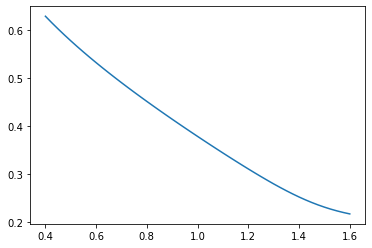

In [7]:
strikes = np.arange(.4, 1.6,.025)
T     = 1.0
theta = 0.4
kappa = 1.5
sigma = 1.5 
rho   = -0.9
ro    = 0.05

feller = sigma*sigma/(2*kappa*theta)
print(feller)

smile = build_smile_np(strikes, 1.0, T, kappa, theta, sigma, ro, rho, 30)

plt.plot(strikes, smile)

### Display Functions

In [8]:

def histo_array(keys, x, title="None"):
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,4))
    if not title == None: fig.suptitle(title)
    for n in range(LEN):
        k     = keys[n]
        lo   = np.min(x[:,n])
        hi   = np.max(x[:,n])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[:,n], density=True, facecolor='g', bins=bins)
        ax[n].set_title(k)
        n += 1
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()


In [9]:

def show_smiles(smiles=None):

    fig, ax = plt.subplots(1,1, figsize=(12,12))
    fig.suptitle("Sample smiles")
    ll = list(smiles.keys())
    ll.sort()
    for t in ll:
        smile = smiles[t]
        ax.plot( smile[:,0], smile[:,1], label = "T=%5.3f" %(t))

    ax.set_title("Sample smiles")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Imp Vol")

    plt.subplots_adjust(left=.10, right=0.7)
    plt.legend(title='Smiles', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [10]:
def histo_dict(df, TAG="000000"):
    keys = list(df.keys())
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,6))
    for n in range(LEN):
        k     = keys[n]
        x     = df[k]
        lo   = np.min(x)
        hi   = np.max(x)
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x, density=True, facecolor='g', bins=bins)
        ax[n].set_title("%s len=%d" %(k,len(x)))
        n += 1

    plt.savefig("pdf_%s.png" %TAG, format="png")
    plt.show()


## Generating DataSet Functions

In [11]:
from tqdm        import tqdm

def mkt_gen(pars = None, kw = None, Xc=10, strikes=None):

    if pars is None: raise Exception("No data to process")
    if kw   is None: raise Exception("No list of tags")
    x = pars

    NUM = len(x[:,0])
    
    X = {}
    for k in strikes:
        tag    = "k=%5.3f" %k
        X[tag] = np.full(NUM,0.0, dtype = np.double)
    
    X["T"]      = np.full(NUM,0.0, dtype = np.double)
    X["Price"]  = np.full(NUM,0.0, dtype = np.double)
    X["Strike"] = np.full(NUM,0.0, dtype = np.double)
    
    __tStart=time.perf_counter()
    pCount = 0
    cCount = 0
    n      = 0
    
    for m in tqdm(range(NUM)):
        Fw    = 1.0
        Kappa = x[m,0]
        Theta = x[m,1]
        sgma  = x[m,2]
        Ro    = x[m,3]
        Rho   = x[m,4]
        # --
        T     = x[m,5]
        K     = x[m,6]

        fwPut = HestonPut(Fw, K, T, Kappa, Theta, sgma, Ro, Rho, 0.0, Xc = Xc)
        if fwPut < max(K-Fw,0.): 
            pCount += 1
            continue

        vol = build_smile(strikes=strikes, Fw=Fw, T= T, Kappa=Kappa, Theta=Theta, sgma=sgma, Ro=Ro, Rho=Rho, Xc=Xc)
        if vol == None: 
            cCount += 1
            continue

        for k in strikes:
            tag       = "k=%5.3f" %k
            X[tag][n] = vol[tag]
        
        X["Price"][n]  = fwPut
        X["Strike"][n] = K
        X["T"][n]      = T
        n += 1
        # ---------------------------------------

    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" %("Seq. pricing", __tEnd - __tStart) )

    nSamples = n

    df = {}
    for s in X.keys():
        df[s] = np.copy(X[s][0:nSamples])
    print("@ %-34s: Violations Put=%d, Call=%d DB=%d out of %d" %("Info", pCount, cCount, nSamples, NUM))
    return pd.DataFrame(df)


In [12]:

def smiles_select(strikes, X, NUMSMILES=1):
    smiles  = {}
    ns = NUMSMILES
    N  = len(X["T"])
    for n in range(N):
        if X["T"][n] > .5: continue

        smile = np.ndarray(shape=(len(strikes),2), dtype=np.double)
        for j in range(len(strikes)):
            k = strikes[j]
            tag = "k=%5.3f" %k
            smile[j,0] = k
            smile[j,1] = X[tag][n]

        T         = X["T"][n]
        smiles[T] = smile
        ns -= 1
        if ns == 0: break

    return smiles


**Constants Definition**

In [13]:
verbose = False
    
outputPrfx    = "full"
challengePrfx = "test"
targetPrfx    = "trgt"
    
EPS           = 0.01
XC            = 10.0
    
# bounds for the random generation of model parameters
# and contract parameters
bounds = { "k":       [ .01   , 1.00]
         , "theta":   [ .01   ,  .80]
         , "sigma":   [ .01   , 1.00]
         , "v0":      [ .01   ,  .80]
         , "rho":     [-.99   , 0.00]
         , "T":       [ 1./12., 2.00]
         , "Strike":  [ .6    , 1.40]
         }

    
NUM     = 100000
TAG     = str(NUM) + "_VFA"
rand    = np.random.RandomState(42)

**Generats and displays the random parameters**

@ Info                              : Feller violations =  43797 out of 100000 ( 43.7970000 %)
@ LHS                               : elapsed 0.0771 sec


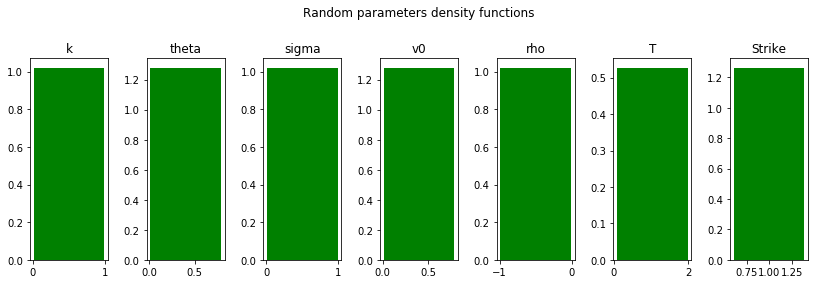

In [14]:
__tStart= time.perf_counter()
kw, x = lhs_sampling(rand, NUM, bounds = bounds)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("LHS", __tEnd - __tStart) )
    
# Let's check the distribution of the parameters we have generated
histo_array(list(kw), x, title = "Random parameters density functions") 

**Generate training/test set**

In [15]:
# strikes used to build the smile used as a feature (regressor)
strikes = np.arange(.8, 1.2, .025)
    
# Generate training/test set
__tStart=time.perf_counter()
df =  mkt_gen( pars = x, kw = kw, Xc=XC, strikes = strikes)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd-__tStart) )

100%|█████████████████████████████████████████████| 100000/100000 [4:38:44<00:00,  5.98it/s]


@ Seq. pricing                      : elapsed 16725.0089 sec
@ Info                              : Violations Put=37, Call=17 DB=99946 out of 100000
@ GEN                               : elapsed 16725.0901 sec


**Select and display a subset of the generated smiles...**

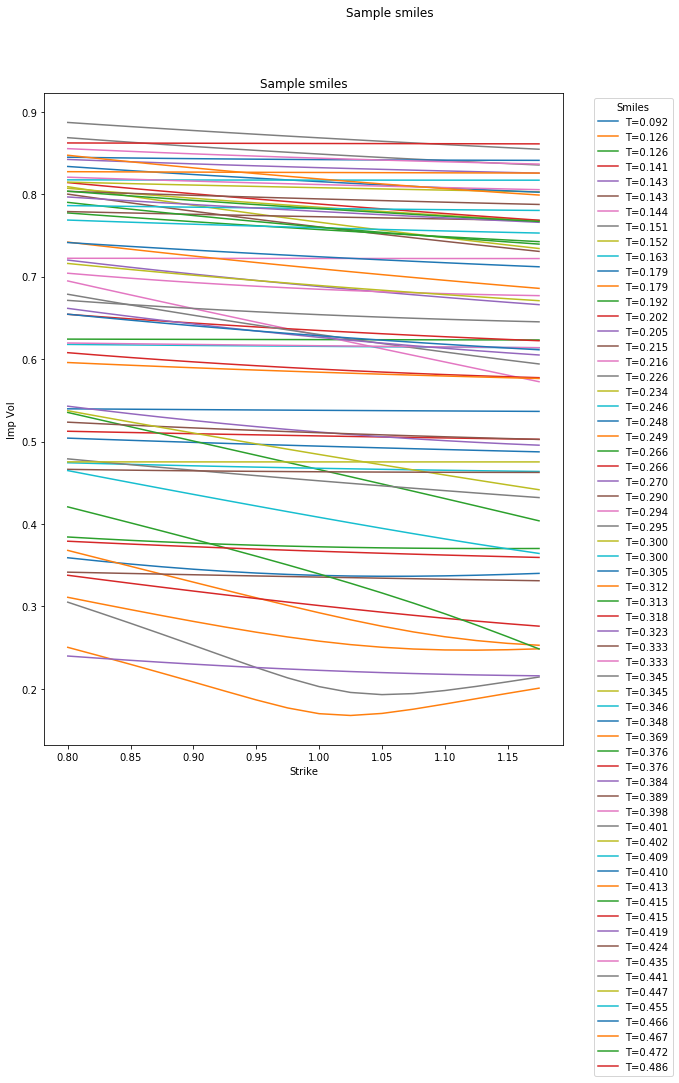

In [16]:
# displays a subset of the generated smiles ....
smiles = smiles_select(strikes, df, NUMSMILES=64)
show_smiles( smiles=smiles)

**Selects a random subset as test set**

In [17]:
Xv, Y = train_test_split(df, test_size=0.33, random_state=rand.randint(42))

**Generate some noise for the training set**

In [18]:
if EPS > 0.0:
    X = Xv.copy()
    xl = np.min(X["Price"])
    xh = np.max(X["Price"])

    xi = rand.normal( loc = 0.0, scale = EPS*(xh-xl), size=X.shape[0])
    X["Price"] += xi
else: X = Xv

**Display the amount of noise**

In [19]:
import warnings
warnings.simplefilter('ignore')

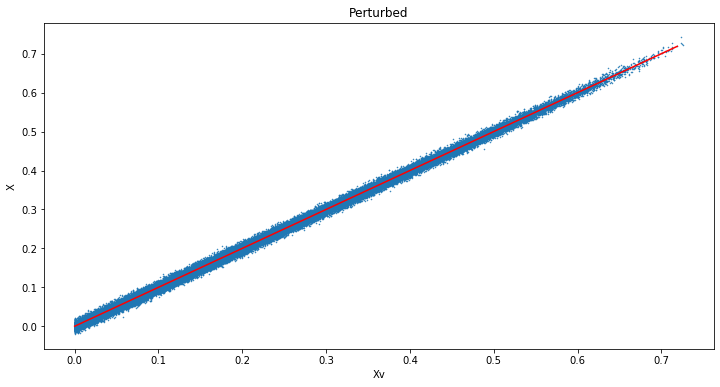

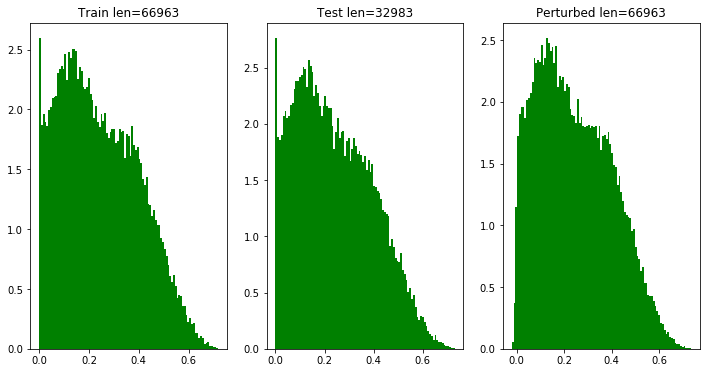

In [20]:
if EPS > 0.0:
    xMin = 0.0
    xMax = max(Xv["Price"])
    v = np.arange(xMin, xMax, (xMax - xMin)/100.)

    fig, ax = plt.subplots(1,1, figsize=(12,6))

    ax.plot( Xv["Price"], X["Price"], ".", markersize=1)
    ax.plot( v, v, color="red")
    ax.set_title("Perturbed")
    ax.set_xlabel("Xv")
    ax.set_ylabel("X")

    figName = "scatter_%s.png" %(TAG)
    plt.savefig(figName, format="png")        

    plt.show()
                
    histo_dict( {"Train": np.array(Xv["Price"]), 
                 "Test": np.array(Y["Price"]), 
                 "Perturbed": np.array(X["Price"]) } , TAG=TAG )
else:
    histo_dict( {"Train": np.array(Xv["Price"]), 
                 "Test": np.array(Y["Price"]) }, TAG=TAG )


**Remove target from challenge set**

In [21]:
t = pd.DataFrame({"Price": Y["Price"]})
y = Y.drop(columns="Price") 

## Saving Result to Disk

**Write training set to disk**

In [22]:
outputFile = "%s_%s.csv" %(outputPrfx, TAG)
X.to_csv(outputFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: training data frame written to '%s'" %("Info", outputFile))
if verbose: print(outputFile); print(X)

@ Info                              : training data frame written to 'full_100000_VFA.csv'


In [23]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(outputFile)    

**Write challenge set to disk**

In [24]:
challengeFile = "%s_%s.csv" %(challengePrfx, TAG)
y.to_csv(challengeFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: challenge data frame written to '%s'" %("Info", challengeFile))
if verbose: print(challengeFile); print(y)

@ Info                              : challenge data frame written to 'test_100000_VFA.csv'


In [25]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(challengeFile)    

**Write target array do disk**

In [26]:
    targetFile = "%s_%s.csv" %(targetPrfx, TAG)
    t.to_csv(targetFile, sep=',', float_format="%.6f", index=False)
    print("@ %-34s: target data frame written to '%s'" %("Info", targetFile))
    if verbose: print(targetFile); print(t)

@ Info                              : target data frame written to 'trgt_100000_VFA.csv'


In [27]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(targetFile)    